In [1]:
from rdkit import Chem, DataStructs
from rdkit.Chem import AllChem
import sqlite3
import pandas as pd
import numpy as np

In [3]:
conn = sqlite3.connect('sabs_moonshot.db')
db=pd.read_sql("""SELECT * FROM compounds WHERE assayed=1""",conn)
db.head()

,id,smiles,MW,NMR_std_ratio,assayed
0,DAR-DIA-23aa0b97-8,N#Cc1cccc(NC(=O)Nc2cncc(N)c2)c1,253.265,,1
1,DAR-DIA-23aa0b97-11,N#Cc1cccc(NC(=O)Nc2c[nH]c3ncccc23)c1,277.287,,1
2,DAR-DIA-23aa0b97-19,N#Cc1cccc(NC(=O)Cc2cncc3ccccc23)c1,287.322,,1
3,DAR-DIA-23aa0b97-20,O=C(Cc1cncc2ccccc12)Nc1ccccc1,262.312,,1
4,WAR-XCH-eb7b662f-2,N#Cc1cc(Cl)cc(NC(=O)Nc2cccnc2)c1,272.695,,1


In [4]:
#Construct a binary fingerprint for each compound in the database
N=len(db)
fps=[]
for i in range(N):
    cur_smiles=db['smiles'].iloc[i]
    cur_molecule=Chem.MolFromSmiles(cur_smiles)
    fps.append(AllChem.GetMorganFingerprintAsBitVect(cur_molecule,2,nBits=2048))

In [6]:
#Construct a similarity matix using Tanimoto index
S=np.zeros((N,N))
for i in range(N):
    for j in range(N):
        S[i,j]=DataStructs.FingerprintSimilarity(fps[i],fps[j],metric=DataStructs.TanimotoSimilarity)
np.save('similarity_matrix',S)

In [25]:
from sklearn.manifold import MDS
mds=MDS(n_components=2,dissimilarity='precomputed')
X=mds.fit_transform(1-S)

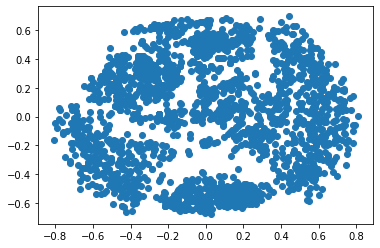

In [26]:
import matplotlib.pyplot as plt
fig = plt.figure()
plt.scatter(X[:,0],X[:,1])